# Evaluate impact of damages for low and high flows

In [1]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import bz2

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *

In [3]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "calibri"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark_blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### Day 1 to 7 forecasts for catchment in southern Murray-Darling basin generated using the MuTHRE method

In [4]:
awrc = '405209'
dataset_filepath = '%s_data.pickle.bz2' % awrc
parallel_nodes = 2
alpha_step = 0.02

In [5]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'].T, data['fcst'].T
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 508)


# Define decision context

In [6]:
decision_definition = {
    'alphas': np.arange(alpha_step, 1, alpha_step),
    'utility_function': [cara, {'A': 0.3}],                                  # minor risk aversion
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_thresholds': None,
    'decision_method': 'optimise_over_forecast_distribution'
}

ref = clim_ens  # use 14-day moving average climatology as the reference forecast

# Dfiner different damage functions

In [7]:
damage_functions = {}

flow_damage_pairs = [
    (0, 1),
    (np.nanquantile(obs, 0.1), 0),      # bottom 10% of flow
    (np.nanquantile(obs, 0.95), 0),     # top 5% of flow
    (np.nanquantile(obs, 0.998), 1)
]
damage_functions['low and high'] = [user_defined, {'interpolator': user_defined_interpolator(flow_damage_pairs)}]

flow_damage_pairs = [
    (0, 0),
    (np.nanquantile(obs, 0.1), 0),
    (np.nanquantile(obs, 0.95), 0),
    (np.nanquantile(obs, 0.998), 1)
]
damage_functions['only high'] = [user_defined, {'interpolator': user_defined_interpolator(flow_damage_pairs)}]

flow_damage_pairs = [
    (0, 1),
    (np.nanquantile(obs, 0.1), 0),
    (np.nanquantile(obs, 0.95), 0),
    (np.nanquantile(obs, 0.998), 0)
]
damage_functions['only low'] = [user_defined, {'interpolator': user_defined_interpolator(flow_damage_pairs)}]

damage_functions['only high (logistic)'] = [logistic, {'k': 1.5, 'A': 1, 'threshold': np.nanquantile(obs, 0.99)}]


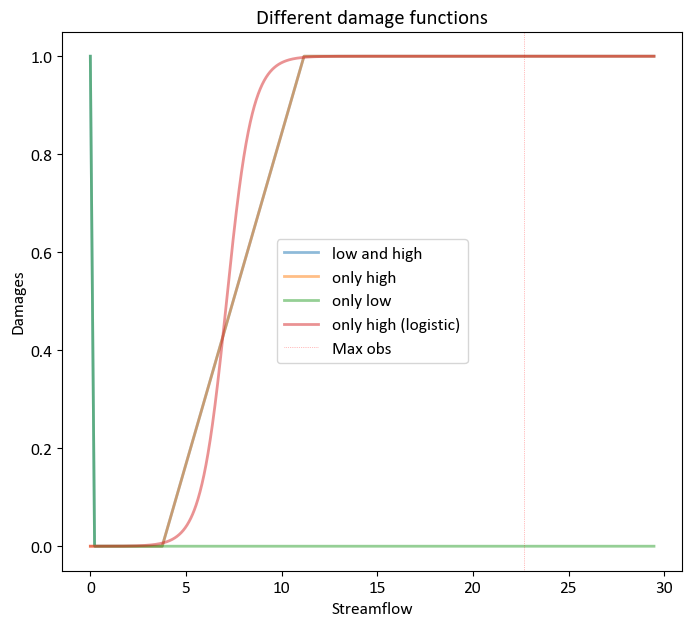

In [8]:
streamflow = np.arange(0, np.nanmax(obs), 0.01) * 1.3
for name, (damage_fnc, params) in damage_functions.items():
    damages = damage_fnc(params)(streamflow)
    plt.plot(streamflow, damages, linewidth=2, alpha=0.5, label=name)

plt.axvline(np.nanmax(obs), color='red', linewidth=0.5, alpha=0.5, linestyle='dotted', label='Max obs')
plt.title('Different damage functions')
plt.xlabel('Streamflow')
plt.ylabel('Damages')
plt.legend()

# Calculate RUV for the different damage functions

In [9]:
results = {}

for name, (damage_fnc, params) in damage_functions.items():
    print(name)
    decision_definition['damage_function'] = [damage_fnc, params]
    results[name] = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes=parallel_nodes)['ruv']

results_df = pd.DataFrame(results, index=decision_definition['alphas'])

low and high
only high
only low
only high (logistic)


# Plot value diagrams for for the different damage functions

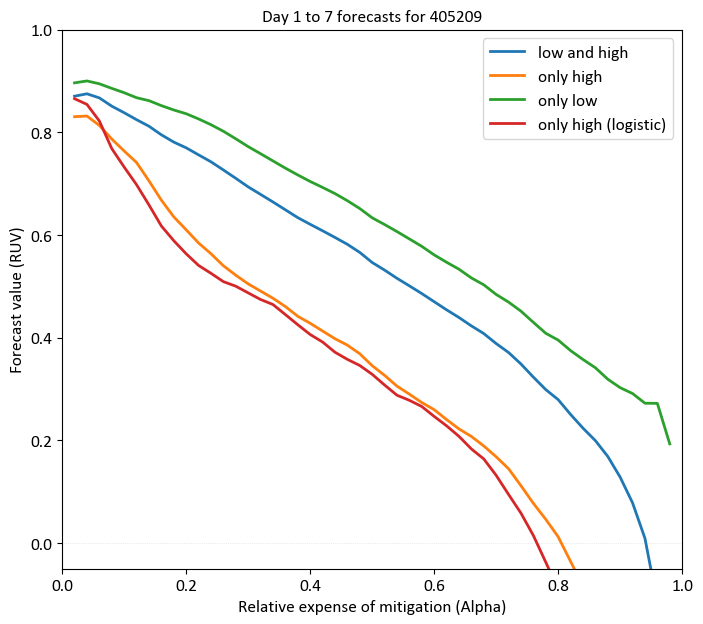

In [10]:
results_df.plot(linewidth=2, alpha=1.0)
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.xlim((0, 1))
plt.ylim(-0.05, 1)
plt.xlabel('Relative expense of mitigation (Alpha)')
plt.ylabel('Forecast value (RUV)')
plt.title('Day 1 to 7 forecasts for %s' % awrc, fontsize='medium')
plt.legend()